In [1]:
# Ensure notebook is being run from base repository directory
COVID_HOME = "/Users/efua/documents/uni/spring-2021/UROP/covid19-forecast-hub"
import os, sys
try:
    os.chdir(COVID_HOME)
except Exception as err:
    print(f"Warning: unable to change directory; {repr(err)}")
from src.utils.notebook_util import isnotebook
if isnotebook():
    # Autoreload packages that are modified
    %load_ext autoreload
    %autoreload 2
else:
    from argparse import ArgumentParser
    
# Computational libraries 
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy.matlib
from collections import deque

# os libraries 
import shutil
from datetime import datetime, timedelta
from functools import partial
import copy
import pdb
import os

from utils import *
from file_util import *
from attributes import *

from zoo_of_experts import *
from zoo_of_hinters import *
from zoo_of_losses import *

import matplotlib.pyplot as plt

In [2]:
#
# Specify model parameters
#
model_name = "online_expert" 

if not isnotebook():
    # If notebook run as a script, parse command-line arguments
    parser = ArgumentParser()
    parser.add_argument("pos_vars",nargs="*")  # gt_id and horizon 
    parser.add_argument('--target_dates', '-t', default="std_future")
    args, opt = parser.parse_known_args()
    
    # Assign variables                                                                                                                                     
    gt_id = get_id_name(args.pos_vars[0]) # "contest_precip" or "contest_tmp2m"                                                                            
    horizon = get_th_name(args.pos_vars[1]) # "34w" or "56w"    
    target_date_str = args.target_dates # target date object
else:
    # Otherwise, specify arguments interactively
    gt_id = "incd_death" #"contest_precip", "contest_tmp2m". choices: "cumm_death", "incd_death", "cumm_case", "incd_case"     
    target_date_str = "std_weekly" #"contest_precip", "contest_tmp2m"
    location = 'US' #US or FIPS code
    quantile = 0.5
    horizon = "1w"

In [3]:
"""
Read in ground truth and model predictions for task
"""
# Get location FIPS codes
fips_codes = get_fips_codes() 

# Read ground truth 
printf(f'Loading {gt_id} ground truth')
df_gt = get_ground_truth(gt_id, location, load_df=True)

# Get target dates
first_date, last_date = get_data_range(gt_id, location=location)
printf(f"Getting target dates from {first_date} to {last_date}.")
target_dates = get_target_dates(target_date_str, first_date, last_date)
target_date_objs = pd.Series(target_dates)

# Store delta between target date and forecast issuance date
start_delta = timedelta(days=get_start_delta(horizon, gt_id))

# Get model predicitons for the task
printf(f'Loading model predictions for {gt_id}, {horizon}, {location}, q{quantile}')
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)

# Get model list
persistant_models, all_models = get_persistant_models(model_pred_df)
expert_models = list(all_models)
expert_models.sort()
model_string = (',').join(expert_models)
printf(f"Predictions for models loaded:\n {expert_models}")

Loading incd_death ground truth
Getting target dates from 2020-01-29 00:00:00 to 2021-04-13 00:00:00.
Loading model predictions for incd_death, 1w, US, q0.5
Predictions for models loaded:
 ['BPagano-RtDriven', 'CEID-Walk', 'COVIDhub-baseline', 'COVIDhub-ensemble', 'COVIDhub-trained_ensemble', 'CU-nochange', 'CU-scenario_high', 'CU-scenario_low', 'CU-scenario_mid', 'CU-select', 'Columbia_UNC-SurvCon', 'Covid19Sim-Simulator', 'CovidAnalytics-DELPHI', 'DDS-NBDS', 'GT-DeepCOVID', 'IHME-CurveFit', 'IUPUI-HkPrMobiDyR', 'Imperial-ensemble1', 'Imperial-ensemble2', 'IowaStateLW-STEM', 'JCB-PRM', 'JHUAPL-Bucky', 'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'MITCovAlliance-SIR', 'MIT_CritData-GBCF', 'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID', 'MSRA-DeepST', 'Microsoft-DeepSTIA', 'NotreDame-mobility', 'OliverWyman-Navigator', 'PSI-DRAFT', 'QJHong-Encounter', 'RPI_UW-Mob_Collision', 'RobertWalraven-ESG', 'SWC-TerminusCM', 'SigSci-TS', 'SteveMcConnell-CovidComple

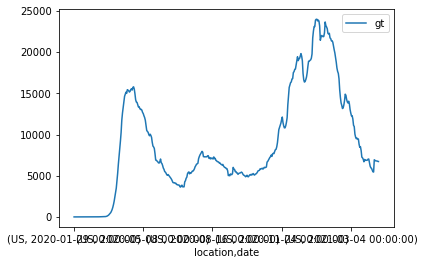

In [4]:
df_gt.plot()

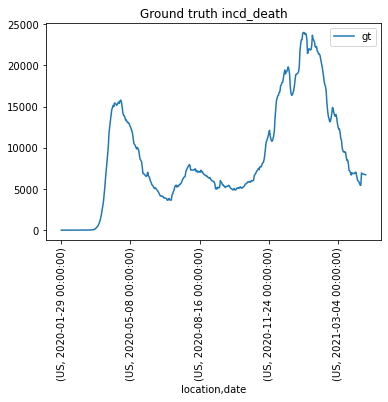

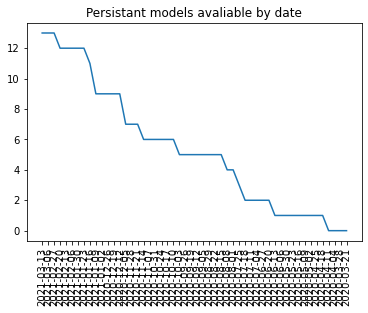

In [5]:
"""
Visualize ground truth 
"""
df_gt.plot()
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()

"""
Visualize avalible models
"""
plt.plot(list(persistant_models.keys()), [len(x) for x in persistant_models.values()])
plt.xticks(rotation=90)
plt.title('Persistant models avaliable by date')
plt.show()

In [6]:
#loading expert models
print("testing: cumulative deaths, 1 wk horizon")
print("")

print("expert models DF:")
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)
model_pred_df.head(1500)


testing: cumulative deaths, 1 wk horizon

expert models DF:


,,,value
model,location,target_end_date,
Imperial-ensemble2,US,2020-03-21,39.000000
Imperial-ensemble1,US,2020-03-21,39.000000
Imperial-ensemble2,US,2020-03-28,645.000000
Imperial-ensemble1,US,2020-03-28,793.000000
Imperial-ensemble2,US,2020-04-04,2135.000000
...,...,...,...
LANL-GrowthRate,US,2021-03-13,10482.500000
SigSci-TS,US,2021-03-13,9658.000000
CEID-Walk,US,2021-03-13,12071.247000


expert model median plot:


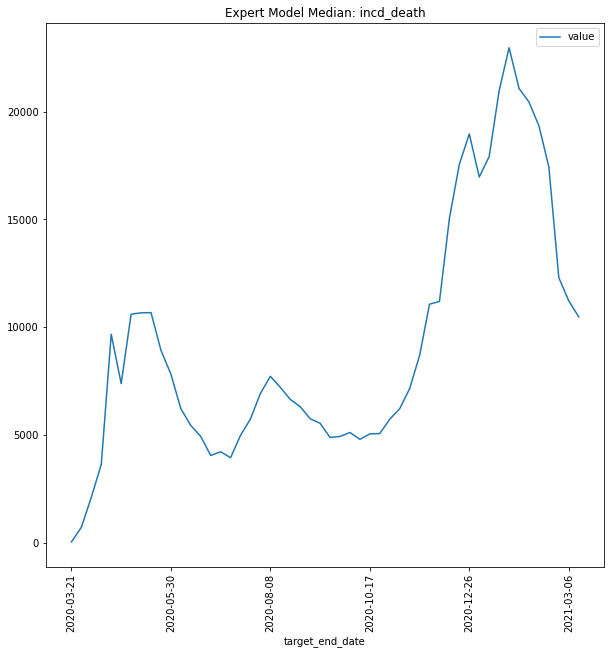


expert model mean plot:


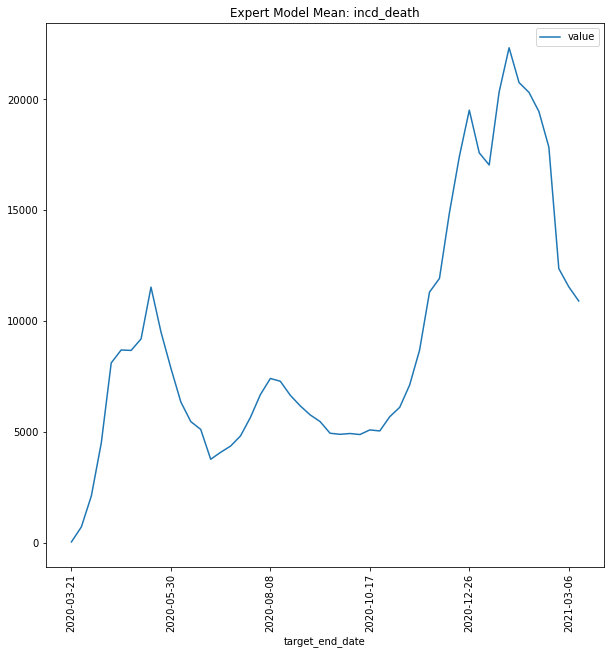


groundtruth plot:


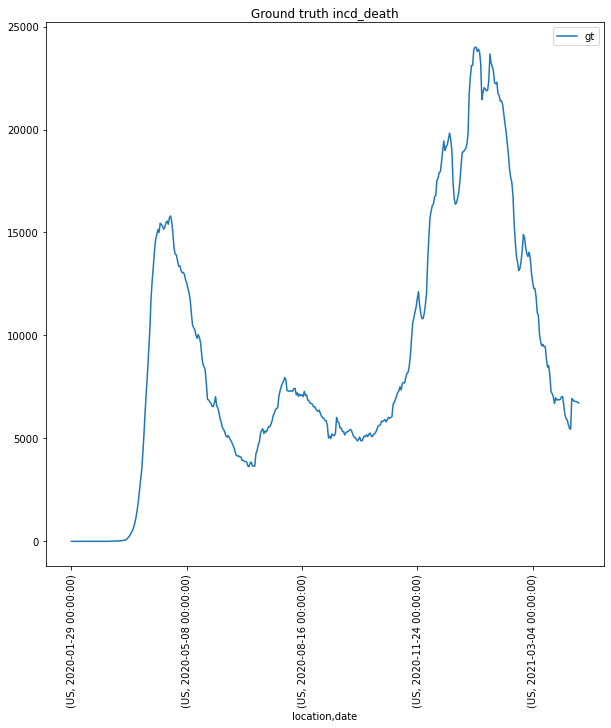

In [7]:
#creating mean and median plots for expert models
print("expert model median plot:")
med_df = model_pred_df.groupby(['target_end_date']).median()
med_df.plot(figsize=(10,10));
plt.xticks(rotation=90)
plt.title(f'Expert Model Median: {gt_id}')
plt.show()



print("")
print("expert model mean plot:")
mea_df = model_pred_df.groupby(['target_end_date']).mean()
mea_df.plot(figsize=(10,10))
plt.xticks(rotation=90)
plt.title(f'Expert Model Mean: {gt_id}')
plt.show()

print("")
print("groundtruth plot:")
df_gt.plot(figsize=(10,10))
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()
print("")


models per date plot:


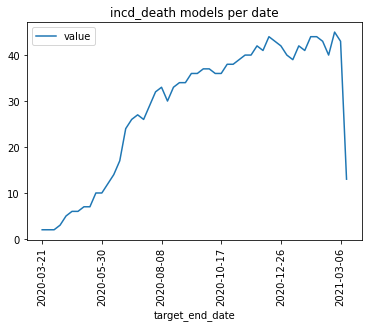

In [8]:
#visualize model count for each date
mod_per_date = model_pred_df.groupby(by='target_end_date').count()
print("")
print("models per date plot:")
mod_per_date.plot()
plt.xticks(rotation=90)
plt.title(f'{gt_id} models per date')
plt.show()
print("")

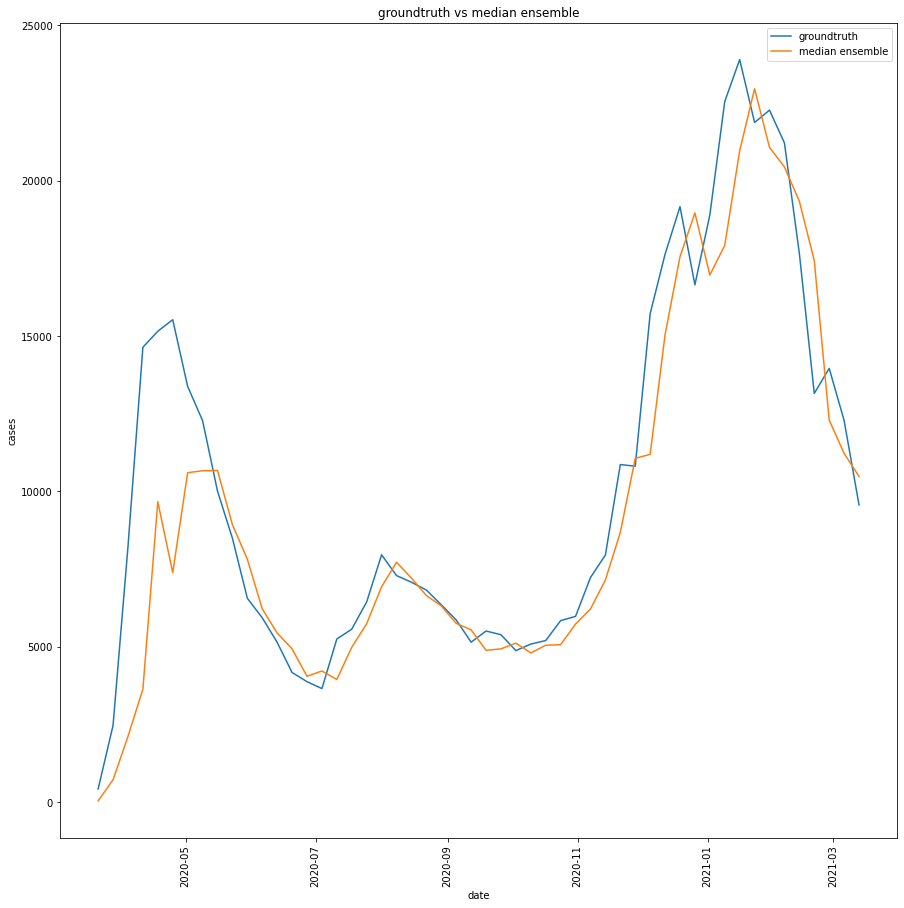

In [9]:
#flatten indexes and extrace dates and cases for axis values
med_model = model_pred_df.groupby(['target_end_date']).median() #load median ensenble again

GT_copy = df_gt #create groundtruth copy and extract axis values
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']


med_model = model_pred_df.groupby(['target_end_date']).median() #create ensemble copy and extract axis values
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_single
MED_xvals = MED_single['target_end_date']
MED_yvals = MED_single['value']

ensemble_dates = MED_xvals.tolist() #get only groundtruth values that match ensenble dates
GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
#combined plot of groundtruth, ensemble (median), and individual models.
plt.figure(figsize=(15,15))
plt.plot(GT_mdates, GT_mvals, label = "groundtruth")
plt.plot(GT_mdates, MED_yvals, label = "median ensemble")
plt.xticks(rotation=90)
plt.title('groundtruth vs median ensemble')
plt.ylabel('cases')
plt.xlabel('date')
plt.legend()
plt.show()


In [10]:
#make median series
MED_copy = med_df
MED_single = MED_copy.reset_index()
MED_dict = {}
for index, row in MED_single.iterrows():
    MED_dict[row["target_end_date"]] = row["value"]

med_series = pd.Series(data=MED_dict, index=MED_single['target_end_date'])

#make groundtruth series
GT_copy = df_gt
GT_single = GT_copy.reset_index()
GT_single
GT_dict = {}
for index, row in GT_single.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_dict[datestr] = row["gt"]
        
GT_series = pd.Series(data=GT_dict, index=MED_single['target_end_date']) #matching gt values to ensemble dates due to missing dates?


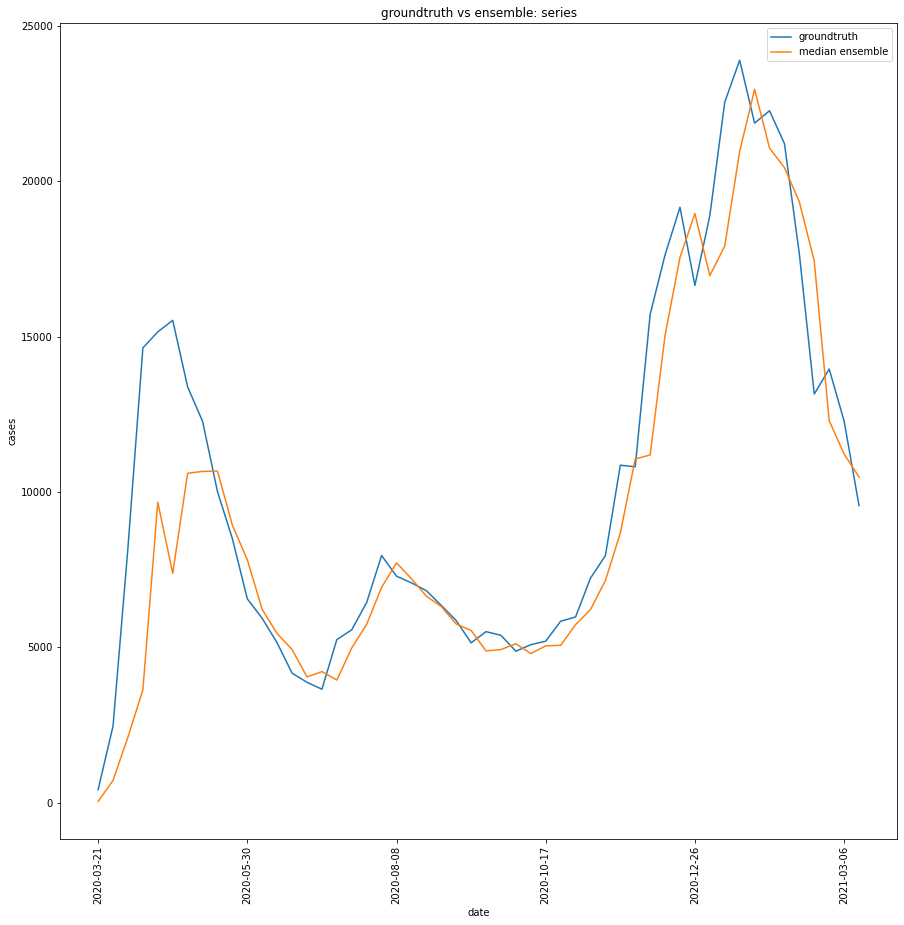

In [11]:
#plot median ensemble series vs groundtruth series
plt.figure(figsize=(15,15))
GT_series.plot(label = "groundtruth")
med_series.plot(label = "median ensemble")
plt.xticks(rotation=90)
plt.title('groundtruth vs ensemble: series')
plt.ylabel('cases')
plt.xlabel('date')
plt.legend()
plt.show()

In [12]:
#loss calculation for ensemble (cumm_deaths)
losses_by_date = MAELoss.loss(0,GT_series,med_series)

#overall average loss
entries = 0
tot = 0
for x in losses_by_date:
    entries += 1
    tot += x
    
error_avg = tot / entries

losses_by_date

target_end_date
2020-03-21      382.000000
2020-03-28     1748.000000
2020-04-04     6100.500000
2020-04-11    11006.000000
2020-04-18     5485.925974
2020-04-25     8144.757985
2020-05-02     2778.943606
2020-05-09     1615.497321
2020-05-16      662.848131
2020-05-23      435.316051
2020-05-30     1257.214080
2020-06-06      287.297194
2020-06-13      299.350907
2020-06-20      761.173182
2020-06-27      174.300364
2020-07-04      567.459583
2020-07-11     1303.503838
2020-07-18      583.489725
2020-07-25      700.000000
2020-08-01     1028.500000
2020-08-08      429.000000
2020-08-15      133.592000
2020-08-22      176.000000
2020-08-29       37.738160
2020-09-05      108.931057
2020-09-12      396.998729
2020-09-19      620.263811
2020-09-26      457.278600
2020-10-03      240.500000
2020-10-10      286.251083
2020-10-17      149.984500
2020-10-24      775.332096
2020-10-31      247.823860
2020-11-07     1012.000000
2020-11-14      804.364979
2020-11-21     2185.000000
2020-11-28  

In [13]:
print("average ensemble error: " + str(error_avg))

average ensemble error: 1669.7661514900078


In [14]:
#ref: median ensemble series
med_series

target_end_date
2020-03-21       39.000000
2020-03-28      719.000000
2020-04-04     2112.500000
2020-04-11     3635.000000
2020-04-18     9671.074026
2020-04-25     7384.242015
2020-05-02    10604.056394
2020-05-09    10665.502679
2020-05-16    10676.848131
2020-05-23     8931.316051
2020-05-30     7820.214080
2020-06-06     6219.297194
2020-06-13     5442.350907
2020-06-20     4932.173182
2020-06-27     4050.300364
2020-07-04     4220.459583
2020-07-11     3946.496162
2020-07-18     4983.510275
2020-07-25     5745.000000
2020-08-01     6930.500000
2020-08-08     7721.000000
2020-08-15     7210.592000
2020-08-22     6650.000000
2020-08-29     6313.261840
2020-09-05     5754.068943
2020-09-12     5543.998729
2020-09-19     4885.736189
2020-09-26     4931.721400
2020-10-03     5116.500000
2020-10-10     4799.748917
2020-10-17     5049.015500
2020-10-24     5066.667904
2020-10-31     5730.176140
2020-11-07     6216.000000
2020-11-14     7149.635021
2020-11-21     8680.000000
2020-11-28  

In [15]:
#ref: groundtruth series
GT_series

target_end_date
2020-03-21      421.0
2020-03-28     2467.0
2020-04-04     8213.0
2020-04-11    14641.0
2020-04-18    15157.0
2020-04-25    15529.0
2020-05-02    13383.0
2020-05-09    12281.0
2020-05-16    10014.0
2020-05-23     8496.0
2020-05-30     6563.0
2020-06-06     5932.0
2020-06-13     5143.0
2020-06-20     4171.0
2020-06-27     3876.0
2020-07-04     3653.0
2020-07-11     5250.0
2020-07-18     5567.0
2020-07-25     6445.0
2020-08-01     7959.0
2020-08-08     7292.0
2020-08-15     7077.0
2020-08-22     6826.0
2020-08-29     6351.0
2020-09-05     5863.0
2020-09-12     5147.0
2020-09-19     5506.0
2020-09-26     5389.0
2020-10-03     4876.0
2020-10-10     5086.0
2020-10-17     5199.0
2020-10-24     5842.0
2020-10-31     5978.0
2020-11-07     7228.0
2020-11-14     7954.0
2020-11-21    10865.0
2020-11-28    10813.0
2020-12-05    15722.0
2020-12-12    17636.0
2020-12-19    19168.0
2020-12-26    16652.0
2021-01-02    18899.0
2021-01-09    22551.0
2021-01-16    23902.0
2021-01-23    21

In [16]:
#incident deaths (US) ------------------------------------------------------------------------------------------

#get model predictions
model_pred_df = get_model_predictions(gt_id, horizon, location=location, quantile=quantile, load_df=True)
model_pred_df.head(100)


,,,value
model,location,target_end_date,
Imperial-ensemble2,US,2020-03-21,39.000000
Imperial-ensemble1,US,2020-03-21,39.000000
Imperial-ensemble2,US,2020-03-28,645.000000
Imperial-ensemble1,US,2020-03-28,793.000000
Imperial-ensemble2,US,2020-04-04,2135.000000
...,...,...,...
COVIDhub-baseline,US,2020-06-20,5313.000000
GT-DeepCOVID,US,2020-06-20,5140.789800
COVIDhub-ensemble,US,2020-06-20,4890.467505


expert model median plot:


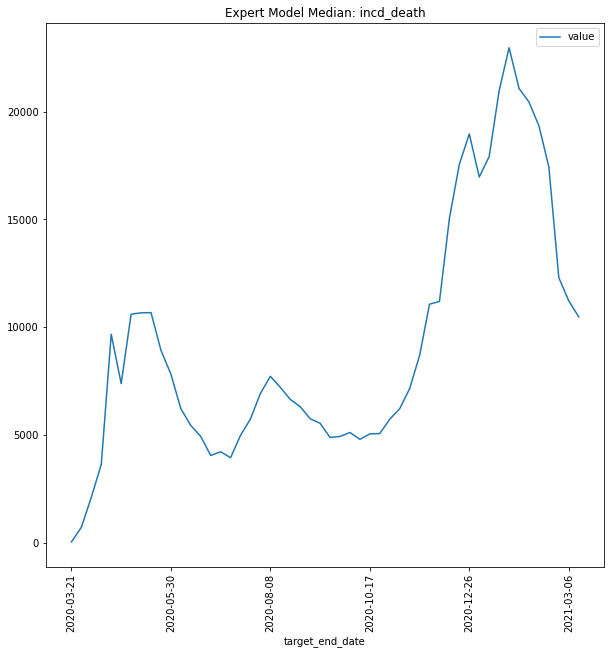


expert model mean plot:


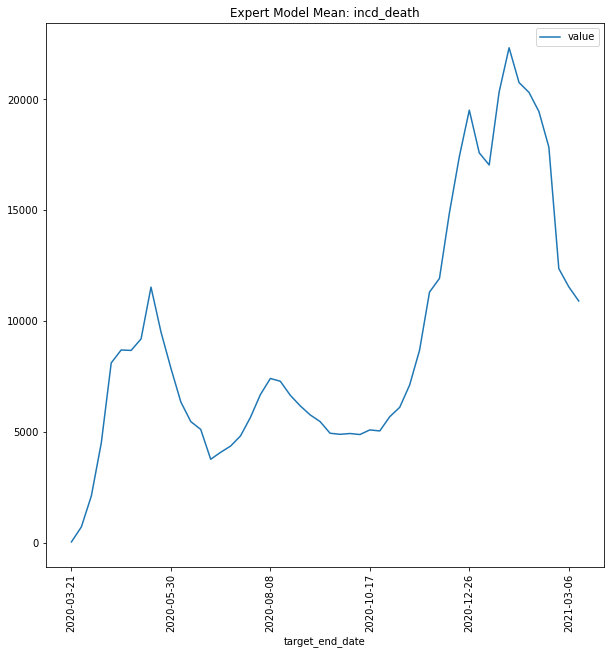


groundtruth plot:


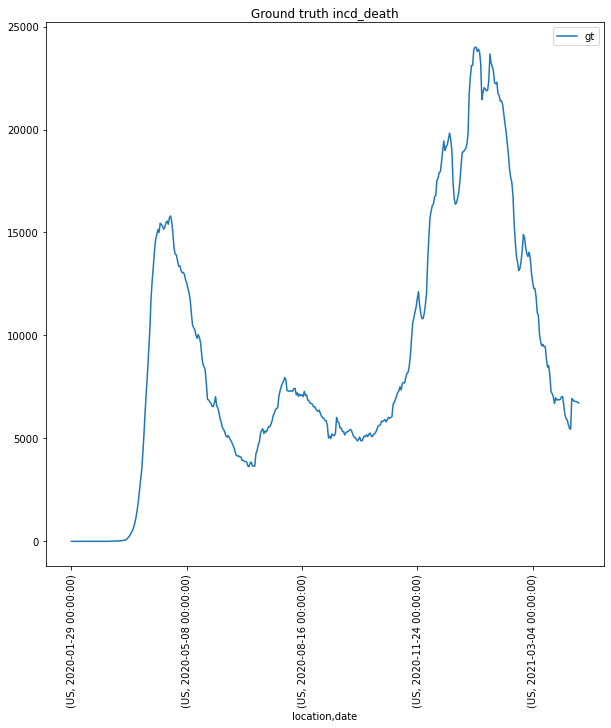

In [17]:
#view median ensemble plot
print("expert model median plot:")
med_df = model_pred_df.groupby(['target_end_date']).median()
med_df.plot(figsize=(10,10));
plt.xticks(rotation=90)
plt.title(f'Expert Model Median: {gt_id}')
plt.show()

#view mean ensemble plot
print("")
print("expert model mean plot:")
mea_df = model_pred_df.groupby(['target_end_date']).mean()
mea_df.plot(figsize=(10,10))
plt.xticks(rotation=90)
plt.title(f'Expert Model Mean: {gt_id}')
plt.show()

#view groundtruth plot
print("")
print("groundtruth plot:")
df_gt.plot(figsize=(10,10))
plt.xticks(rotation=90)
plt.title(f'Ground truth {gt_id}')
plt.show()
print("")

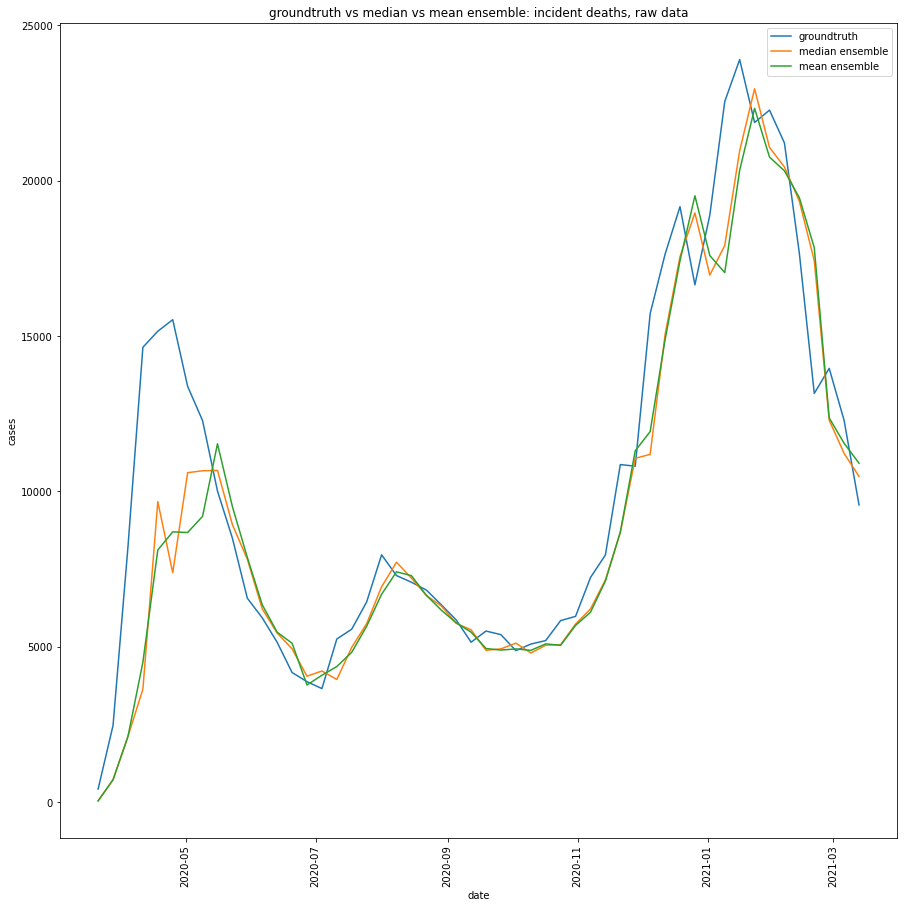

In [18]:
#create raw data plot of ensembles vs groundtruth
med_model = model_pred_df.groupby(['target_end_date']).median() #load median ensenble again

GT_copy = df_gt 
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']


med_model = model_pred_df.groupby(['target_end_date']).median() 
MED_copy = med_model
MED_single = MED_copy.reset_index()
MED_xvals = MED_single['target_end_date']
MED_yvals = MED_single['value']

ensemble_dates = MED_xvals.tolist() 
GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
mea_model = model_pred_df.groupby(['target_end_date']).mean()
MEA_copy = mea_model
MEA_single = MEA_copy.reset_index()
MEA_xvals = MEA_single['target_end_date']
MEA_yvals = MEA_single['value']
        
#combined plot of groundtruth, ensemble (median), and individual models.
plt.figure(figsize=(15,15))
plt.plot(GT_mdates, GT_mvals, label = "groundtruth")
plt.plot(GT_mdates, MED_yvals, label = "median ensemble")
plt.plot(GT_mdates, MEA_yvals, label = "mean ensemble")
plt.xticks(rotation=90)
plt.title('groundtruth vs median vs mean ensemble: incident deaths, raw data')
plt.ylabel('cases')
plt.xlabel('date')
plt.legend()
plt.show()

In [19]:
#generate series
#make median series
MED_copy = med_df
MED_single = MED_copy.reset_index()
MED_dict = {}
for index, row in MED_single.iterrows():
    MED_dict[row["target_end_date"]] = row["value"]

med_series = pd.Series(data=MED_dict, index=MED_single['target_end_date'])

#make groundtruth series
GT_copy = df_gt
GT_single = GT_copy.reset_index()
GT_single
GT_dict = {}
for index, row in GT_single.iterrows():
    dat = row["date"].date()
    datestr = dat.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_dict[datestr] = row["gt"]
        
GT_series = pd.Series(data=GT_dict, index=MED_single['target_end_date']) #matching gt values to ensemble dates due to missing dates?

#make mean series
MEA_copy = med_df
MEA_single = MED_copy.reset_index()
MEA_dict = {}
for index, row in MEA_single.iterrows():
    MEA_dict[row["target_end_date"]] = row["value"]

mea_series = pd.Series(data=MEA_dict, index=MEA_single['target_end_date'])

In [20]:
#cumulative overall error
losses_mea = MAELoss.loss(0,GT_series,mea_series)
entries = 0
tot = 0
for x in losses_mea:
    entries += 1
    tot += x
    
mean_avg = tot / entries
print(f"mean overall error: {mean_avg}")
print("")


losses_med = MAELoss.loss(0,GT_series,med_series)
entries2 = 0
tot2 = 0
for x in losses_med:
    entries2 += 1
    tot2 += x
    
med_avg = tot2 / entries2
print(f"median overall error: {med_avg}")
print("")

mean overall error: 1669.7661514900078

median overall error: 1669.7661514900078



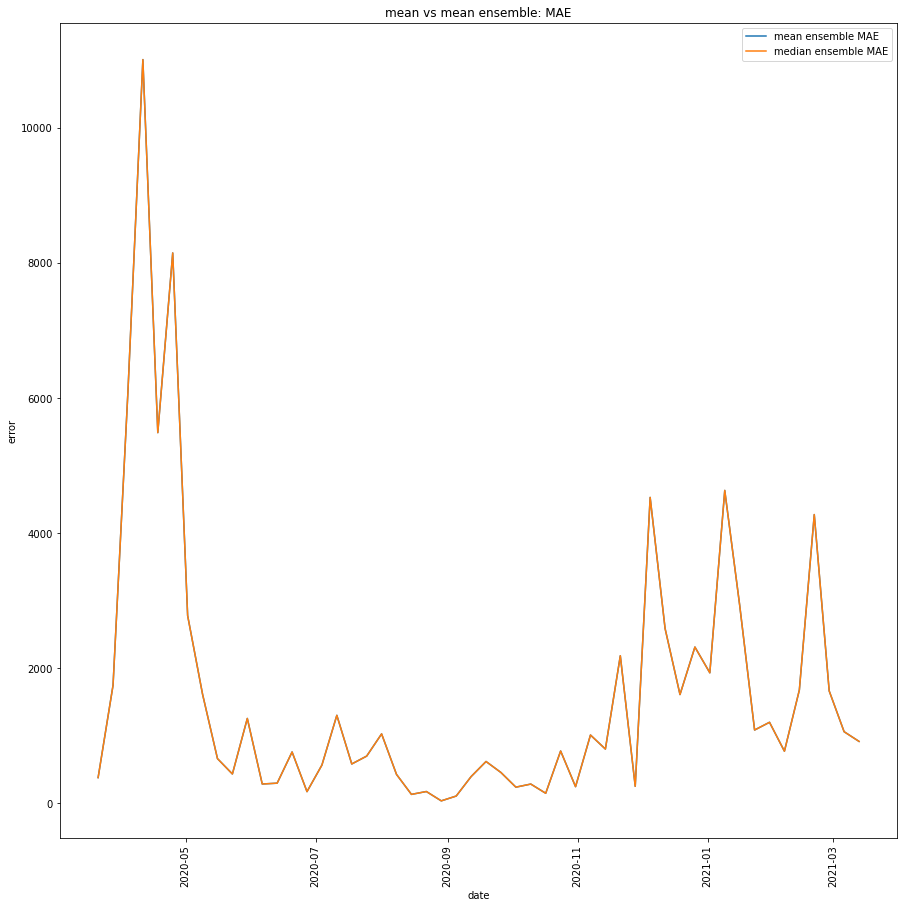

In [21]:
allDates = GT_mdates

#plot losses
plt.figure(figsize=(15,15))
plt.plot(allDates, losses_mea.values, label = "mean ensemble MAE")
plt.plot(allDates, losses_med.values, label = "median ensemble MAE")
plt.xticks(rotation=90)
plt.title('mean vs mean ensemble: MAE')
plt.ylabel('error')
plt.xlabel('date')
plt.legend()
plt.show()

In [22]:
#abbreviation to fips, hard code ver.
locCode = 0;
def FIPSconvert(entry):
    FIPSdict = {
        "US": "US",
        "AL": 1,
        "AK": 2,
        "AZ": 4,
        "AR": 5,
        "CA": 6,
        "CO": 8,
        "CT": 9,
        "DE": 10,
        "DC": 11,
        "FL": 12,
        "GA": 13,
        "HI": 15,
        "ID": 16,
        "IL": 17,
        "IN": 18,
        "IA": 19,
        "KS": 20,
        "KY": 21,
        "LA": 22,
        "ME": 23,
        "MD": 24,
        "MA": 25,
        "MI": 26,
        "MN": 27,
        "MS": 28,
        "MO": 29,
        "MT": 30,
        "NE": 31,
        "NV": 32,
        "NH": 33,
        "NJ": 34,
        "NM": 35,
        "NY": 36,
        "NC": 37,
        "ND": 38,
        "OH": 39,
        "OK": 40,
        "OR": 41,
        "PA": 42,
        "RI": 44,
        "SC": 45,
        "SD": 46,
        "TN": 47,
        "TX": 48,
        "UT": 49,
        "VT": 50,
        "VA": 51,
        "WA": 53,
        "WV": 54,
        "WI": 55,
        "WY": 56,
        "AS": 60,
        "GU": 66,
        "MP": 69,
        "PR": 72,
        "UM": 74,
        "VI": 78,
    }
    
    if entry in FIPSdict:
        locCode = FIPSdict.get(entry)
        print(f"{entry} is {locCode}")
        
FIPSconvert("PR")


PR is 72


In [23]:
#individual models

#LIST: ['BPagano-RtDriven', 'CEID-Walk', 'COVIDhub-baseline', 'COVIDhub-ensemble', 'COVIDhub-trained_ensemble', 
#'CU-nochange', 'CU-scenario_high', 'CU-scenario_low', 'CU-scenario_mid', 'CU-select', 'Columbia_UNC-SurvCon', 
#'Covid19Sim-Simulator', 'CovidAnalytics-DELPHI', 'DDS-NBDS', 'GT-DeepCOVID', 'IHME-CurveFit', 'IUPUI-HkPrMobiDyR', 
#'Imperial-ensemble1', 'Imperial-ensemble2', 'IowaStateLW-STEM', 'JCB-PRM', 'JHUAPL-Bucky', 'JHU_CSSE-DECOM', 
#'JHU_IDD-CovidSP', 'Karlen-pypm', 'LANL-GrowthRate', 'LNQ-ens1', 'MITCovAlliance-SIR', 'MIT_CritData-GBCF', 
#'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID', 'MSRA-DeepST', 'Microsoft-DeepSTIA', 'NotreDame-mobility', 
#'OliverWyman-Navigator', 'PSI-DRAFT', 'QJHong-Encounter', 'RPI_UW-Mob_Collision', 'RobertWalraven-ESG', 
#'SWC-TerminusCM', 'SigSci-TS', 'SteveMcConnell-CovidComplete', 'UA-EpiCovDA', 'UCLA-SuEIR', 'UCM_MESALab-FoGSEIR', 
#'UCSD_NEU-DeepGLEAM', 'UChicagoCHATTOPADHYAY-UnIT', 'UMass-MechBayes', 'UMich-RidgeTfReg', 'USACE-ERDC_SEIR', 
#'USC-SI_kJalpha', 'USC-SI_kJalpha_RF', 'UT-Mobility', 'UpstateSU-GRU', 'YYG-ParamSearch', 'epiforecasts-ensemble1']

for model, df in model_pred_df.groupby(['model']):
    print(df)

                                                 value
model            location target_end_date             
BPagano-RtDriven US       2020-10-10        4606.99800
                          2020-10-17        5065.03100
                          2020-10-24        5685.18411
                          2020-10-31        6203.87848
                          2020-11-07        6376.63682
                          2020-11-14        7755.99537
                          2020-11-21        9127.25940
                          2020-11-28       12448.68576
                          2020-12-05       13631.91744
                          2020-12-12       16967.44395
                          2020-12-19       20175.52765
                          2020-12-26       20056.70046
                          2021-01-02       18588.42779
                          2021-01-09       19975.98618
                          2021-01-16       21179.01463
                          2021-01-23       23017.05222
          

                               2021-03-06       12241.971325
                                      value
model     location target_end_date         
PSI-DRAFT US       2020-07-11        3689.5
                   2020-07-18        4799.5
                   2020-07-25        5219.0
                   2020-08-01        7392.5
                   2020-08-08       10193.5
                   2020-08-15        7546.0
                   2020-08-22        5686.5
                   2020-08-29        6743.5
                   2020-09-05        6189.5
                   2020-09-12        5917.5
                   2020-09-19        4530.0
                   2020-09-26        4632.5
                   2020-10-03        4568.5
                   2020-10-10        3933.5
                   2020-10-17        3817.5
                   2020-10-24        3814.5
                   2020-10-31        4340.5
                   2020-11-07        5615.0
                   2020-11-14        5537.0
               

                         2020-10-10        4700.008766
                                                        value
model                  location target_end_date              
epiforecasts-ensemble1 US       2020-06-20        5547.000000
                                2020-06-27        4696.000000
                                2020-07-04        4290.333333
                                2020-07-11        3100.500000
                                2020-07-18        4725.000000
                                2020-07-25        5175.000000
                                2020-08-01        8237.000000
                                2020-08-08        7794.000000
                                2020-08-15        7619.000000
                                2020-08-22        7345.000000
                                2020-08-29        6108.000000
                                2020-09-05        5940.000000
                                2020-09-12        5461.000000
               

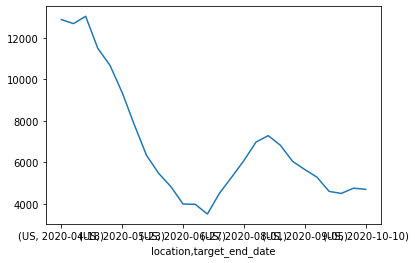

In [24]:
#YYG model
fig, axes = plt.subplots(1, 1)
model_pred_df['value']['YYG-ParamSearch'].plot(axes=axes)

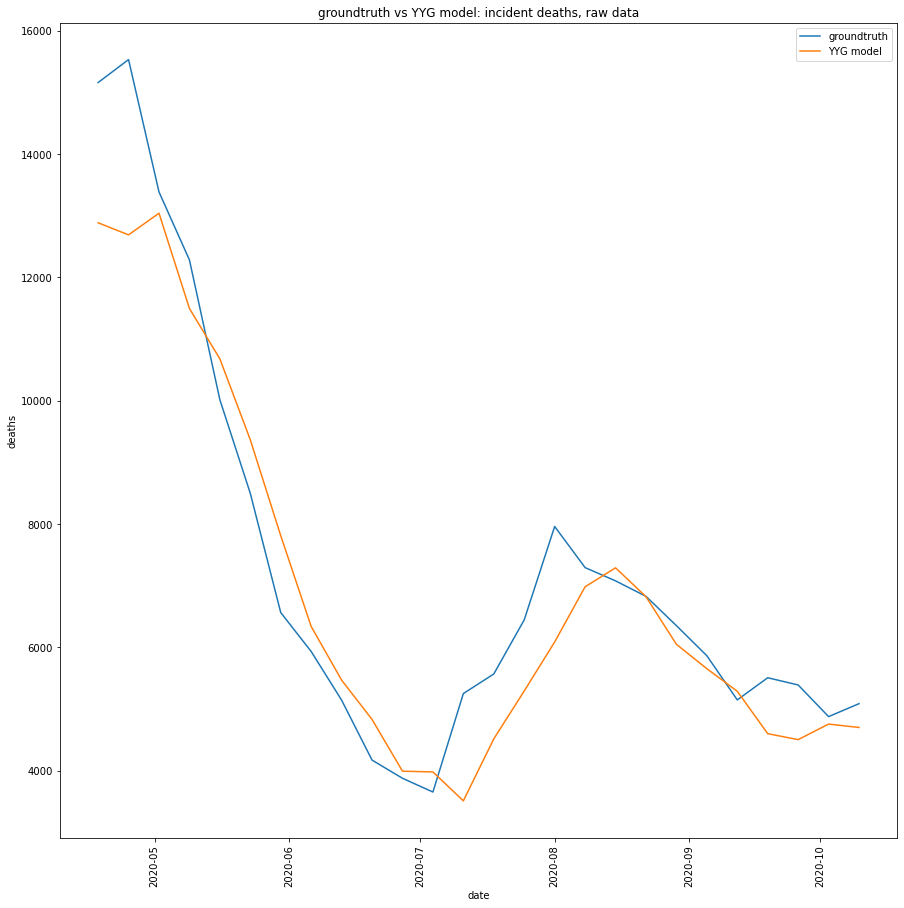

In [25]:
YYG_model = model_pred_df['value']['YYG-ParamSearch']

GT_copy = df_gt 
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']


YYG_model = model_pred_df['value']['YYG-ParamSearch']
YYG_copy  = YYG_model.reset_index()
YYG_xvals = YYG_copy['target_end_date']
YYG_yvals = YYG_copy['value']

ensemble_dates = YYG_xvals.tolist() 
GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
#combined plot of groundtruth and individual model (YYG) for YYG dates.
plt.figure(figsize=(15,15))
plt.plot(GT_mdates, GT_mvals, label = "groundtruth")
plt.plot(GT_mdates, YYG_yvals, label = "YYG model")
plt.xticks(rotation=90)
plt.title('groundtruth vs YYG model: incident deaths, raw data')
plt.ylabel('deaths')
plt.xlabel('date')
plt.legend()
plt.show()

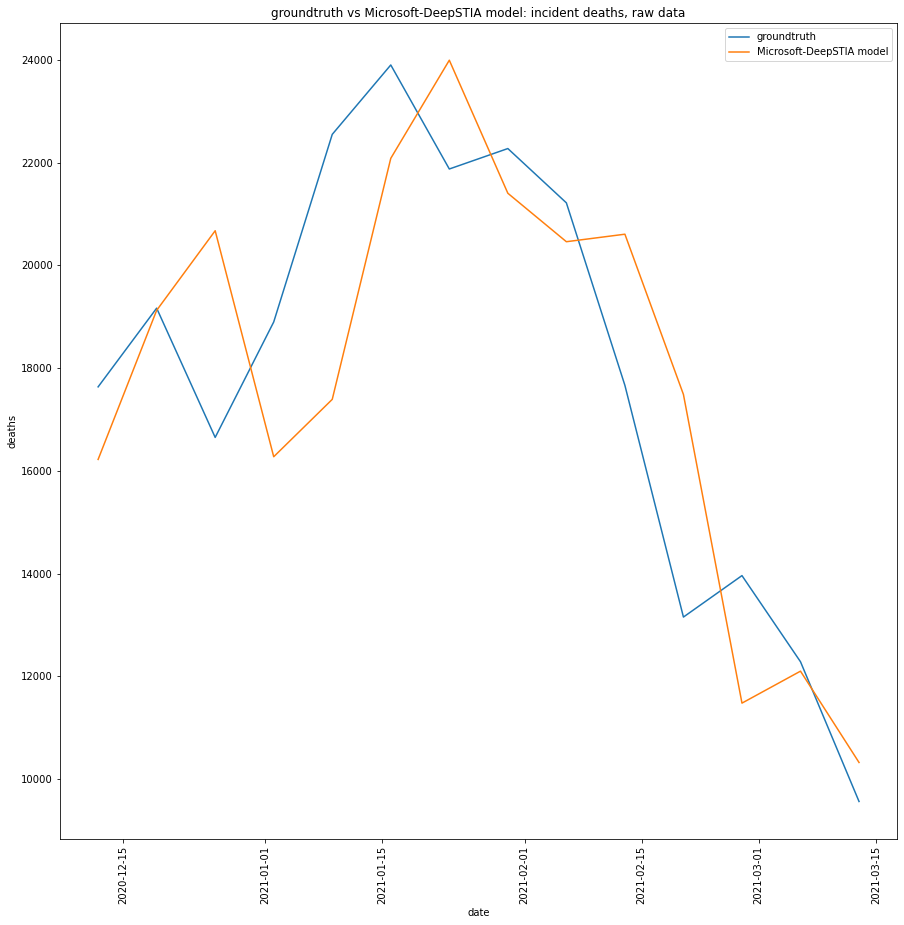

In [26]:
GT_copy = df_gt 
GT_single = GT_copy.reset_index()
GT_xvals = GT_single['date']
GT_yvals = GT_single['gt']


STIA_model = model_pred_df['value']['Microsoft-DeepSTIA']
STIA_copy  = STIA_model.reset_index()
STIA_xvals = STIA_copy['target_end_date']
STIA_yvals = STIA_copy['value']

ensemble_dates = STIA_xvals.tolist() 
GT_mdates = []
GT_mvals = []
for index, row in GT_single.iterrows():
    date = row["date"].date()
    val = row["gt"]
    form = '{dat}'
    datestr = date.strftime("%Y-%m-%d")
    if datestr in ensemble_dates:
        GT_mdates.append(date)
        GT_mvals.append(val)
        
#combined plot of groundtruth and individual model (STIA) for STIA dates.
plt.figure(figsize=(15,15))
plt.plot(GT_mdates, GT_mvals, label = "groundtruth")
plt.plot(GT_mdates, STIA_yvals, label = "Microsoft-DeepSTIA model")
plt.xticks(rotation=90)
plt.title('groundtruth vs Microsoft-DeepSTIA model: incident deaths, raw data')
plt.ylabel('deaths')
plt.xlabel('date')
plt.legend()
plt.show()